#### In this notebook:
- brief EDA
- horisonatal projections of wells and seismic cube 
- visualize seismic slices 
- process las files adding well coordinates 
- generate training data - project wells on vertical seismic slices 
- visualize training data: seismic slices, carotage masks (used in loss funstion), target carotage data 

### Download the dataset

In [ ]:
! TMP=$(mktemp -d)
! [ ! -f $TMP/ml-recipe-seismic.zip ] && wget http://data.neu.ro/ml-recipe-seismic.zip -O $TMP/ml-recipe-seismic.zip    
! unzip -o $TMP/ml-recipe-seismic.zip -d $DATA_PATH

In [10]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

# make user code available:
import sys
from pathlib import Path
module_path = Path('.').absolute().parent
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path / 'src'))

import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from data_types import Point
from utils import projection
from create_dataset import (
    generate_logs, gen_tgt_mask,
    project_wells_onto_slice,
    create_slice_well_list,
    process_single_wells,
    dump_normalization_values,
    slice_crossline, slice_inline
)
from const import (
    log_dir, # processed well logs
    slices_dir, # path to generated training data
    slice_coord_path, # dictionary with ilines, xlines coordinates
    trace_coords, # coordinates of seismic traces
    ilines, xlines,
    nsamples, dt, # seismic cube parameters
    wells, wellheads, # well names and well heads coordinates
    norm_dict_path, # narmalization dictionary for neural net
    well_width, # width of vertical well prjection, in seismic traces
    carotage_types
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# seismic cube parameters
print(f'# samples={nsamples}, dt={dt} msec')
print(f'min iline={min(ilines)}, max iline={max(ilines)}')
print(f'min xline={min(xlines)}, max xline={max(xlines)}')

### Horisonatal projection of wells and seismic traces

In [ ]:
# read ilines and xlines coordinates
with open(slice_coord_path, 'rb') as f:
    slice_coord_dict = pickle.load(f)

In [ ]:
xline = 387
xline_coords = slice_coord_dict['xline'][xline]

fig = plt.figure(figsize=(10, 10))
plt.scatter(trace_coords[::1, 0], trace_coords[::1, 1], marker='.')
plt.scatter(xline_coords[:, 0], xline_coords[:, 1], marker='.', s=20, c='y')
plt.scatter(wellheads['X-Coord'], wellheads['Y-Coord'], marker='o', s=100, c='k')
for id_, (x_, y_) in wellheads.iterrows():
    plt.annotate(id_, xy=[x_, y_], xytext=(10, 3), textcoords='offset points', c='w', fontsize=16)
plt.legend(['Seismic traces', f'xline {xline}', 'Wells'], loc='lower right')
plt.title(f'Horisonatal projection of well heads')
plt.xlabel('X, m', fontsize=12)
plt.ylabel('Y, m', fontsize=12)
plt.show()

#### Well F03-4 projection on inline 730

In [ ]:
well_name = 'F03-4'
slice_type = 'iline'
slice_num = 730

slice_coords = slice_coord_dict[slice_type][slice_num]

ptw = Point(*wellheads.loc[well_name, ['X-Coord', 'Y-Coord']])
pt1 = Point(*slice_coords[0])
pt2 = Point(*slice_coords[-1])
ptp = projection(pt1, pt2, ptw)

fig = plt.figure(figsize=(10, 10))
plt.scatter(trace_coords[::1, 0], trace_coords[::1, 1], marker='.')
plt.scatter(slice_coords[:, 0], slice_coords[:, 1], marker='.', s=20, c='y')
plt.scatter(*pt1, marker='o', s=100, c='r')
plt.scatter(*pt2, marker='o', s=100, c='g')
plt.scatter(*ptw, marker='o', s=100, c='k')
plt.scatter(*ptp, marker='o', s=100, c='c')
plt.legend(['seismic traces', f'{slice_type} {slice_num}', 'start', 'end', f'head of {well_name}', f'{well_name} projection on {slice_type}'], loc='lower right')
plt.title(f'Horisonatal projection of well {well_name} on {slice_type} {slice_num}')
plt.xlabel('X, m', fontsize=12)
plt.ylabel('Y, m', fontsize=12)
plt.show()

### Visualize inline

In [ ]:
iline = 730
seismic_slice = slice_inline(iline)

fig = plt.figure(figsize=(10, 15))
plt.imshow(seismic_slice, cmap = 'seismic', aspect = 'auto')
plt.axis('off')
plt.title(f'Inline {iline}')
plt.show()

### Visualize crossline

In [ ]:
xline = 400
seismic_slice = slice_crossline(xline)

fig = plt.figure(figsize=(10, 15))
plt.imshow(seismic_slice, cmap = 'seismic', aspect = 'auto')
plt.axis('off')
plt.title(f'Crossline {xline}')
plt.show()

### Preprocess and extend log files

In [ ]:
generate_logs(wells, log_dir)

### Plot carotage data

In [ ]:
well_name = 'F03-4'
las_df = pd.read_csv(log_dir / (well_name + '.csv'))

In [ ]:
fontsize = 14
fig, axes = plt.subplots(1, 3, figsize=(10, 20), sharey=True)
las_df.plot(y='t', x='Sonic', ax=axes[0], legend=None, fontsize=fontsize)
las_df.plot(y='t', x='Gamma_Ray', ax=axes[1], legend=None, fontsize=fontsize)
las_df.plot(y='t', x='Porosity', ax=axes[2], legend=None, fontsize=fontsize)
axes[0].set_ylabel('ms', fontsize=fontsize)
axes[0].grid('on')
axes[1].grid('on')
axes[2].grid('on')
plt.gca().invert_yaxis()

### Project single well onto seismic slice

In [ ]:
well_name = 'F03-4'
iline = 730
iline_coords = slice_coord_dict['iline'][iline]
las_df = pd.read_csv(log_dir / (well_name + '.csv'))
vertical_grid = np.arange(nsamples) * dt
target, mask = gen_tgt_mask(iline_coords, vertical_grid, las_df, carotage_types=['P_Impedance'], well_width=20)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30), sharey=True)
extent = [min(xlines), max(xlines), nsamples * dt - 1, 0]
ax1.imshow(mask[..., 0], cmap='Greys_r', extent=extent)
ax1.set_title('Mask')
ax1.set_ylabel('ms', fontsize = '10')
ax1.set_xlabel('xline', fontsize = '10')
ax2.imshow(target[..., 0], cmap='Spectral_r', extent=extent)
ax2.set_title('P_Impedance(Kg/m2s)')
ax2.set_xlabel('xline', fontsize = '10')
plt.tight_layout()
plt.show()

### Project multiple wells

In [ ]:
well_list = ['F02-1', 'F03-2']
xline = 740
carotage_list = ['Gamma_Ray', 'P_Impedance']
target, mask = project_wells_onto_slice(xline, 'xline', well_list, carotage_types=carotage_types, well_width=20, verbose=True)

### Vizualise mask and carotage target

In [ ]:
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0]
carotage = 'Gamma_Ray'
index = carotage_list.index(carotage)

fontsize = 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30), sharey=True)
ax1.imshow(mask[..., index], cmap='Greys_r', extent=extent)
ax1.set_title('Mask')
ax1.set_ylabel('ms', fontsize=fontsize)
ax1.set_xlabel('iline', fontsize=fontsize)
ax2.imshow(target[..., index], cmap='Spectral_r', extent=extent)
ax2.set_title(f'{carotage} carotage')
ax2.set_xlabel('iline', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [ ]:
carotage = 'P_Impedance'
index = carotage_list.index(carotage)

fontsize = 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30), sharey=True)
ax1.imshow(mask[..., index], cmap='Greys_r', extent=extent)
ax1.set_title('Mask')
ax1.set_ylabel('ms', fontsize=fontsize)
ax2.set_xlabel('iline', fontsize=fontsize)
ax2.imshow(target[..., index], cmap='Spectral_r', extent=extent)
ax2.set_title(f'{carotage} carotage')
ax2.set_xlabel('iline', fontsize=fontsize)
plt.tight_layout()
plt.show()

### Generate training data

In [ ]:
print('Generate well/slice projections')
slice_well_list = create_slice_well_list(wells)
process_single_wells(slice_well_list, carotage_types, well_width, slices_dir)

print('\nCreate normalization dictionary')
dump_normalization_values(slices_dir, path=norm_dict_path, overwrite=True)

### Visualize training data

In [ ]:
fl = 'iline_732_F03-2.pkl'
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0] if 'xline' in fl else [min(xlines), max(xlines), nsamples * dt - 1, 0]
with open(slices_dir / fl, 'rb') as f:
    slice_data = pickle.load(f)

fontsize = 14
carotage_type = 'P_Impedance'
seismic_ver = slice_data['seismic']
mask_ver = slice_data['projections'][carotage_type]['mask']
target_ver = slice_data['projections'][carotage_type]['target']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 14), sharey=True)
ax1.imshow(seismic_ver, cmap='seismic', extent=extent)
ax1.set_title('Seismogram', fontsize=fontsize)
ax1.set_ylabel('ms', fontsize=fontsize)
ax1.set_xlabel('iline' if 'xline' in fl else 'xline', fontsize=fontsize)

ax2.imshow(mask_ver, cmap='Greys_r', extent=extent)
ax2.set_xlabel('iline' if 'xline' in fl else 'xline', fontsize=fontsize)
ax2.set_title('Mask', fontsize=fontsize)

ax3.imshow(target_ver, cmap='Spectral_r', extent=extent)
ax3.set_xlabel('iline' if 'xline' in fl else 'xline', fontsize=fontsize)
ax3.set_title(f'{carotage_type} carotage', fontsize=fontsize)
plt.tight_layout()
plt.show()

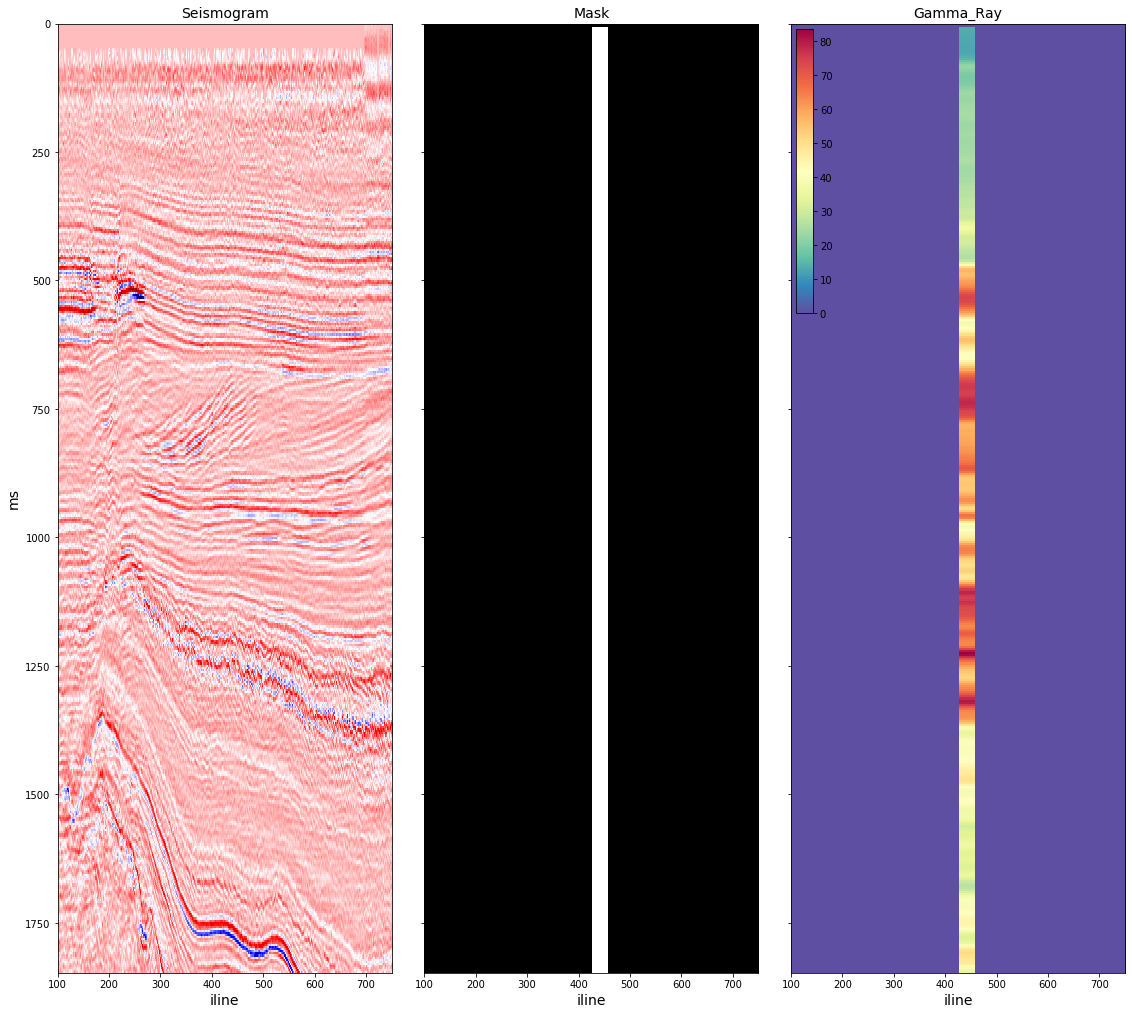

In [24]:
fl = 'xline_1006_F03-4.pkl'
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0] if 'xline' in fl else [min(xlines), max(xlines), nsamples * dt - 1, 0]
with open(slices_dir / fl, 'rb') as f:
    slice_data = pickle.load(f)

fontsize = 14
carotage_type = 'Gamma_Ray'
seismic_ver = slice_data['seismic']
mask_ver = slice_data['projections'][carotage_type]['mask']
target_ver = slice_data['projections'][carotage_type]['target']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 14), sharey=True)
ax1.imshow(seismic_ver, cmap='seismic', extent=extent)
ax1.set_title('Seismogram', fontsize=fontsize)
ax1.set_ylabel('ms', fontsize=fontsize)
ax1.set_xlabel('iline' if 'xline' in fl else 'xline', fontsize=fontsize)

ax2.imshow(mask_ver, cmap='Greys_r', extent=extent)
ax2.set_xlabel('iline' if 'xline' in fl else 'xline', fontsize=fontsize)
ax2.set_title('Mask', fontsize=fontsize)

im = ax3.imshow(target_ver, cmap='Spectral_r', extent=extent)
ax3.set_xlabel('iline' if 'xline' in fl else 'xline', fontsize=fontsize)
ax3.set_title(f'{carotage_type}', fontsize=fontsize)

axins = inset_axes(ax3, width='5%',   height='30%', loc='upper left')
fig.colorbar(im, cax=axins)

plt.tight_layout()
plt.show()